# Import Libraries

In [87]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator,DirectoryIterator
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras import backend as K
import os
import tensorflow as tf

# Generate Training Data

In [111]:
dir_ = os.path.join('D:/Dataset/Cat Dog Panda/')

In [89]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                  validation_split = 0.2)
#test_datagen = ImageDataGenerator(rescale=1/255)
train_generator = train_datagen.flow_from_directory(dir_,target_size=(100, 100),
                                                   batch_size= 1920,
                                                   class_mode='categorical',
                                                   shuffle=False,
                                                   subset = 'training')

test_generator = train_datagen.flow_from_directory(dir_,
                                                          target_size = (100,100),
                                                          batch_size = 480,
                                                          class_mode = 'categorical',
                                                          shuffle=False,
                                                          subset = 'validation')



Found 1920 images belonging to 3 classes.
Found 480 images belonging to 3 classes.


In [90]:
x_train, y_train = next(train_generator)
x_test, y_test  = next(test_generator)

In [91]:
test_filepath = []
for filepath in test_generator.filepaths:
    filepath = filepath.replace('\\', '/')
    test_filepath.append(filepath)

# Build Custom Model

In [92]:
model = Sequential([
    
    # First convolution
        Conv2D(16, (3,3), activation='relu', input_shape=(100, 100, 3)),
        MaxPooling2D(2, 2),
    
    # Second convolution
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D(2,2),
    
    # Third convolution
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
    
        Flatten(),
    
    # Dense hidden layer
        Dense(512, activation='relu'),
        Dropout(0.2),
    
    # Output neuron. 
        Dense(3, activation='softmax') 
])

In [93]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
      train_generator,  
      epochs=80,
      verbose=1)

Epoch 1/80
1/1 [==============================] - 0s 2ms/step - loss: 1.1177 - accuracy: 0.3292
Epoch 2/80
1/1 [==============================] - 0s 2ms/step - loss: 2.7960 - accuracy: 0.3333
Epoch 3/80
1/1 [==============================] - 0s 2ms/step - loss: 1.3364 - accuracy: 0.3354
Epoch 4/80
1/1 [==============================] - 0s 2ms/step - loss: 1.1481 - accuracy: 0.3333
Epoch 5/80
1/1 [==============================] - 0s 2ms/step - loss: 1.1460 - accuracy: 0.3271
Epoch 6/80
1/1 [==============================] - 0s 997us/step - loss: 1.1395 - accuracy: 0.3333
Epoch 7/80
1/1 [==============================] - 0s 0s/step - loss: 1.1260 - accuracy: 0.3333
Epoch 8/80
1/1 [==============================] - 0s 999us/step - loss: 1.1077 - accuracy: 0.3333
Epoch 9/80
1/1 [==============================] - 0s 1ms/step - loss: 1.0936 - accuracy: 0.3344
Epoch 10/80
1/1 [==============================] - 0s 998us/step - loss: 1.0843 - accuracy: 0.4964
Epoch 11/80
1/1 [=================

In [94]:
model.save('lime_default')

INFO:tensorflow:Assets written to: lime_default\assets


In [95]:
model = tf.keras.models.load_model('lime_default')

# Predict an Image with Custom Model

In [152]:
from skimage import io
from tensorflow.keras.preprocessing import image

url = 'https://raw.githubusercontent.com/marcellusruben/All_things_medium/main/Lime/panda_00024.jpg'

def read_and_transform_img(url):

    img = skimage.io.imread(url)
    img = skimage.transform.resize(img, (100,100))
    
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    return img

images = read_and_transform_img(url)

preds = model.predict(images)
prediction = np.argmax(preds)
pct = np.max(preds)

if prediction == 0:
    print('It\'s a cat!')
elif prediction == 1:
    print('It\'s a dog!')
else:
    print('It\'s a panda!')

print(pct)

It's a panda!
0.8097356


In [153]:
from tensorflow.keras.applications import inception_v3 as inc_net
from lime import lime_image

In [154]:
explainer = lime_image.LimeImageExplainer()

# LIME with Custom Model

In [155]:
explanation = explainer.explain_instance(images[0].astype('double'), model.predict,  
                                         top_labels=3, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

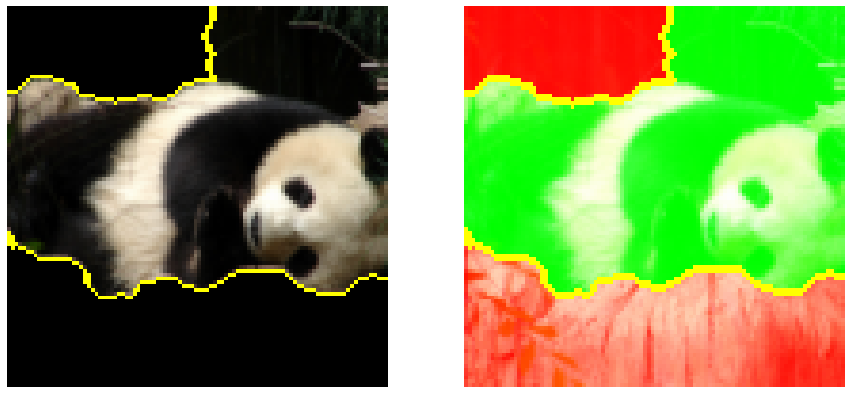

In [156]:
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

plt.savefig('mask_default.png')


# LIME with Inception V3

In [157]:
from tensorflow.keras.applications.imagenet_utils import decode_predictions

In [158]:
inet_model = inc_net.InceptionV3()

In [164]:
def transform_img_fn_ori(url):
    
    img = skimage.io.imread(url)
    img = skimage.transform.resize(img, (299,299))
    img = (img - 0.5)*2
    img = np.expand_dims(img, axis=0)
    preds = inet_model.predict(img)
    for i in decode_predictions(preds)[0]:
        print(i)
    return x

In [165]:
images_inc_im = transform_img_fn_ori(url)

('n02510455', 'giant_panda', 0.9283561)
('n04266014', 'space_shuttle', 0.0027297079)
('n04254680', 'soccer_ball', 0.0008145094)
('n02002556', 'white_stork', 0.0006521639)
('n02509815', 'lesser_panda', 0.0006084189)


In [166]:
explanation= explainer.explain_instance(images_inc_im[0].astype('double'), inet_model.predict,  top_labels=3, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

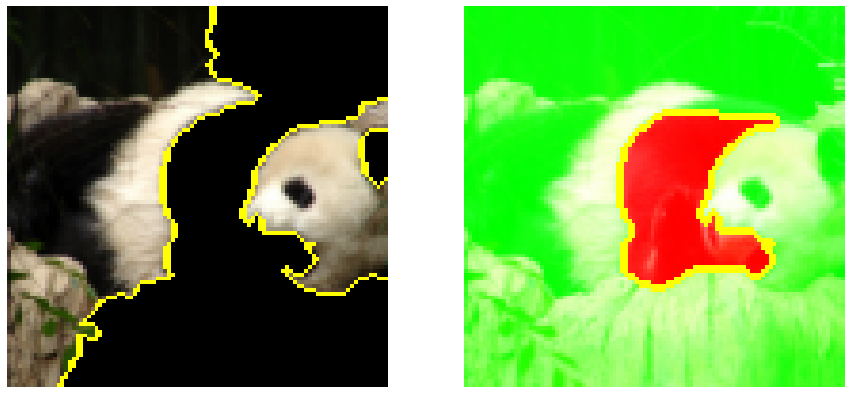

In [167]:
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

plt.savefig('mask_inception.png')